In [ ]:
# BibliotecaComunitaria_Analisis.ipynb

# ---
# title: "Análisis Exploratorio de Bibliotecas Comunitarias"
# author: "Luis Eduardo Higuera Calderon"
# date: "2024-11-18"
# ---

# Análisis Exploratorio de Bibliotecas Comunitarias de Bogotá

En este cuaderno, realizaremos un análisis exploratorio de las bibliotecas comunitarias de Bogotá utilizando Neo4j y Python. Utilizaremos la clase `Neo4jRepository` para conectarnos a la base de datos y ejecutar consultas que nos permitirán obtener información valiosa sobre:

1. **Distribución geográfica de las bibliotecas**
2. **Presencia en redes sociales**
3. **Tipos de colecciones disponibles**
5. **Uso de tecnología y conectividad**
6. **Servicios ofrecidos por las bibliotecas**

Comencemos importando las librerías necesarias y estableciendo la conexión con Neo4j.



## Configuración Inicial

In [1]:
# Importar las librerías necesarias
from neo4j import GraphDatabase, exceptions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

load_dotenv()

# Configurar visualizaciones
%matplotlib inline
sns.set(style="whitegrid")

# Importar la clase Neo4jRepository
from etl.graph_db.neo4j_repository import Neo4jRepository
from etl.utils.models import Neo4JConfig 

# Establecer conexión con Neo4j
config = Neo4JConfig()

neo4j_repo = Neo4jRepository(config.uri, config.user, config.password)

2024-11-18 08:40:10,207 - INFO - Neo4jRepository initialized with URI: bolt://localhost:7687


# 1. Análisis de la Distribución Geográfica de las Bibliotecas
Objetivo: Identificar cuántas bibliotecas comunitarias hay en cada localidad y visualizar su distribución.

In [3]:
def obtener_distribucion_bibliotecas(tx):
    query = """
    MATCH (b:BibliotecaComunitaria)-[:PERTENECE_A]->(l:Localidad)
    RETURN l.nombre AS Localidad, COUNT(b) AS NumeroDeBibliotecas
    ORDER BY NumeroDeBibliotecas DESC
    """
    result = tx.run(query)
    return pd.DataFrame([record.data() for record in result])

# Ejecutar la consulta
df_distribucion = neo4j_repo.execute_read(obtener_distribucion_bibliotecas)

# Mostrar los primeros registros
df_distribucion.head()


,Localidad,NumeroDeBibliotecas
0,Ciudad Bolivar,28
1,Kennedy,23
2,Suba,22
3,Usme,15
4,Bosa,13


C:\Users\luise\AppData\Local\Temp\ipykernel_19920\3458794570.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_distribucion, x='NumeroDeBibliotecas', y='Localidad', palette='viridis')


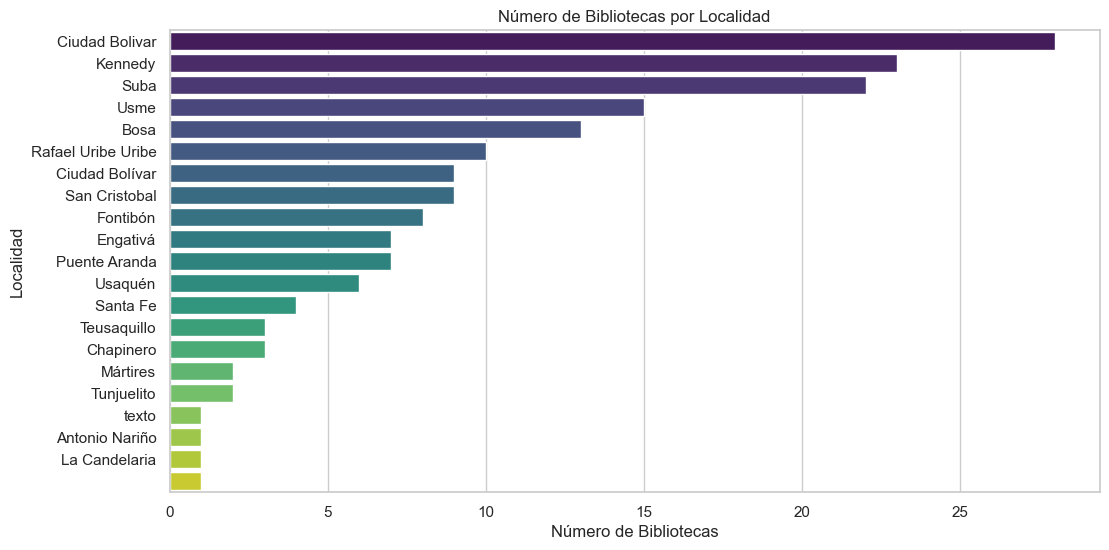

In [4]:
# Gráfico de barras de número de bibliotecas por localidad
plt.figure(figsize=(12, 6))
sns.barplot(data=df_distribucion, x='NumeroDeBibliotecas', y='Localidad', palette='viridis')
plt.title('Número de Bibliotecas por Localidad')
plt.xlabel('Número de Bibliotecas')
plt.ylabel('Localidad')
plt.show()


# 2. Presencia en Redes Sociales
Objetivo: Evaluar la presencia digital de las bibliotecas y en qué plataformas están activas.

In [5]:
def obtener_presencia_redes(tx):
    query = """
    MATCH (b:BibliotecaComunitaria)-[:TIENE_REDES_SOCIALES]->(r:RedesSociales)
    RETURN 
      COUNT(DISTINCT b) AS TotalBibliotecasConRedes,
      SUM(CASE WHEN r.facebook IS NOT NULL AND r.facebook <> '' THEN 1 ELSE 0 END) AS ConFacebook,
      SUM(CASE WHEN r.instagram IS NOT NULL AND r.instagram <> '' THEN 1 ELSE 0 END) AS ConInstagram,
      SUM(CASE WHEN r.youtube IS NOT NULL AND r.youtube <> '' THEN 1 ELSE 0 END) AS ConYouTube
    """
    result = tx.run(query)
    return result.single().data()

# Ejecutar la consulta
redes_data = neo4j_repo.execute_read(obtener_presencia_redes)

# Convertir a DataFrame para facilitar la visualización
df_redes = pd.DataFrame({
    'Red Social': ['Facebook', 'Instagram', 'YouTube'],
    'Número de Bibliotecas': [redes_data['ConFacebook'], redes_data['ConInstagram'], redes_data['ConYouTube']]
})

df_redes


,Red Social,Número de Bibliotecas
0,Facebook,55
1,Instagram,48
2,YouTube,31


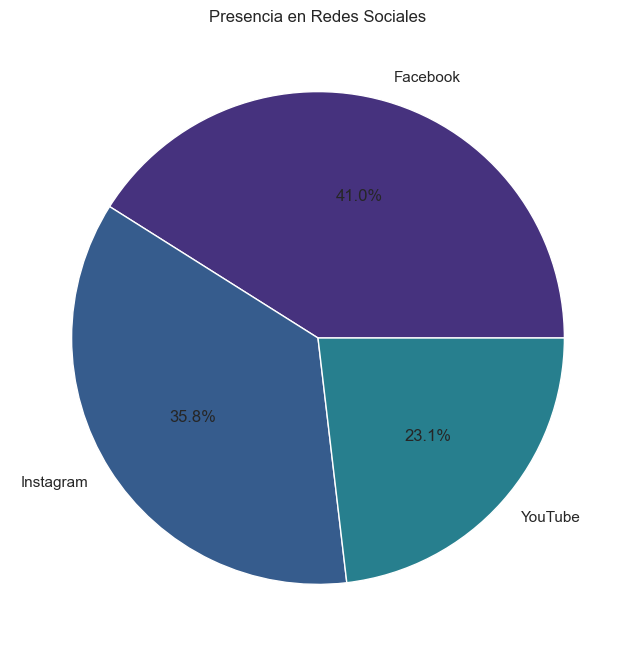

In [6]:
# Gráfico de pastel de presencia en redes sociales
plt.figure(figsize=(8, 8))
plt.pie(df_redes['Número de Bibliotecas'], labels=df_redes['Red Social'], autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.title('Presencia en Redes Sociales')
plt.show()


# 3. Tipos de Colecciones Disponibles
Objetivo: Identificar los tipos de colecciones más comunes entre las bibliotecas.

In [7]:
def obtener_tipos_colecciones(tx):
    query = """
    MATCH (b:BibliotecaComunitaria)-[:TIENE_TIPO_COLECCION]->(tc:TipoColeccion)
    RETURN tc.nombre AS TipoDeColeccion, COUNT(b) AS NumeroDeBibliotecas
    ORDER BY NumeroDeBibliotecas DESC
    """
    result = tx.run(query)
    return pd.DataFrame([record.data() for record in result])

# Ejecutar la consulta
df_colecciones = neo4j_repo.execute_read(obtener_tipos_colecciones)

# Mostrar los primeros registros
df_colecciones.head()


,TipoDeColeccion,NumeroDeBibliotecas
0,literatura,43
1,infantiles,38
2,informativos,35
3,texto,33
4,didacticos,31


C:\Users\luise\AppData\Local\Temp\ipykernel_19920\2101938035.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_colecciones, x='NumeroDeBibliotecas', y='TipoDeColeccion', palette='viridis')


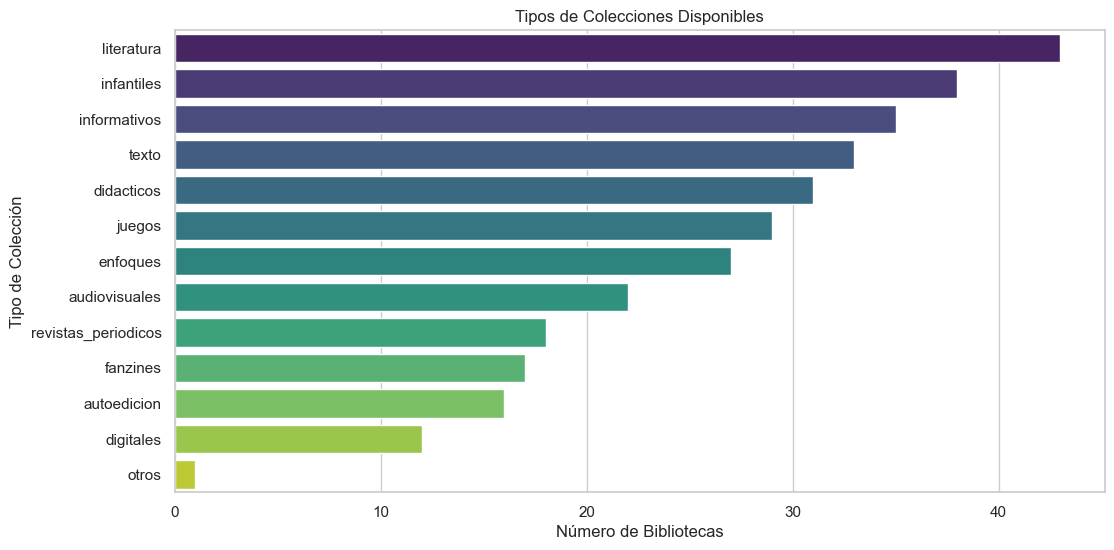

In [8]:
# Gráfico de barras de tipos de colecciones
plt.figure(figsize=(12, 6))
sns.barplot(data=df_colecciones, x='NumeroDeBibliotecas', y='TipoDeColeccion', palette='viridis')
plt.title('Tipos de Colecciones Disponibles')
plt.xlabel('Número de Bibliotecas')
plt.ylabel('Tipo de Colección')
plt.show()


# 5. Uso de Tecnología y Conectividad
Objetivo: Analizar la disponibilidad de tecnología y conectividad en las bibliotecas.

In [9]:
def obtener_uso_tecnologia(tx):
    query = """
    MATCH (b:BibliotecaComunitaria)-[:USA_TECNOLOGIA]->(t:Tecnologia)
    RETURN t.conectividad AS Conectividad, COUNT(b) AS NumeroDeBibliotecas
    """
    result = tx.run(query)
    return pd.DataFrame([record.data() for record in result])

# Ejecutar la consulta
df_tecnologia = neo4j_repo.execute_read(obtener_uso_tecnologia)

# Mostrar los registros
df_tecnologia


,Conectividad,NumeroDeBibliotecas
0,False,148
1,True,27


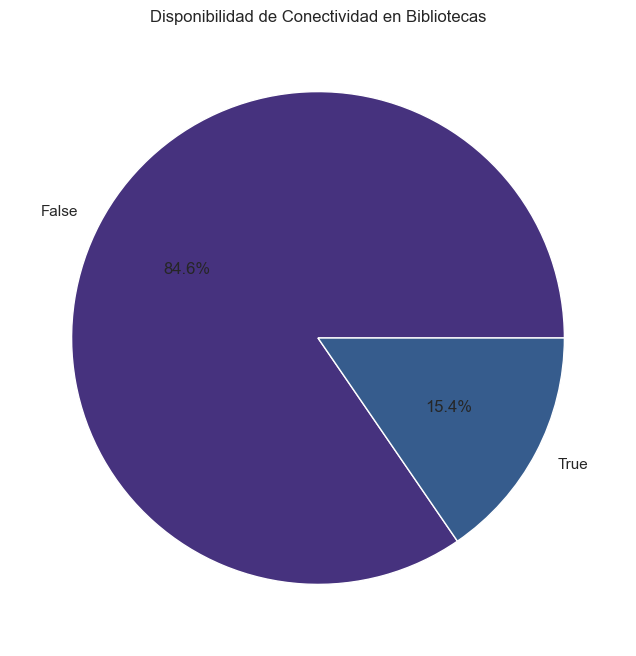

In [10]:
# Gráfico de pastel de conectividad
plt.figure(figsize=(8, 8))
plt.pie(df_tecnologia['NumeroDeBibliotecas'], labels=df_tecnologia['Conectividad'], autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.title('Disponibilidad de Conectividad en Bibliotecas')
plt.show()


# 6. Servicios Ofrecidos por las Bibliotecas
Objetivo: Conocer los servicios más comunes que ofrecen las bibliotecas comunitarias.

In [11]:
def obtener_servicios_ofrecidos(tx):
    query = """
    MATCH (b:BibliotecaComunitaria)-[:OFRECE]->(s:TipoServicio)
    RETURN s.nombre AS Servicio, COUNT(b) AS NumeroDeBibliotecas
    ORDER BY NumeroDeBibliotecas DESC
    """
    result = tx.run(query)
    return pd.DataFrame([record.data() for record in result])

# Ejecutar la consulta
df_servicios = neo4j_repo.execute_read(obtener_servicios_ofrecidos)

# Mostrar los primeros registros
df_servicios.head()


,Servicio,NumeroDeBibliotecas
0,culturales,40
1,comunitarios,39
2,leo,38
3,consulta,37
4,prestamo_externo,27


C:\Users\luise\AppData\Local\Temp\ipykernel_19920\2882540613.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_servicios, x='NumeroDeBibliotecas', y='Servicio', palette='viridis')


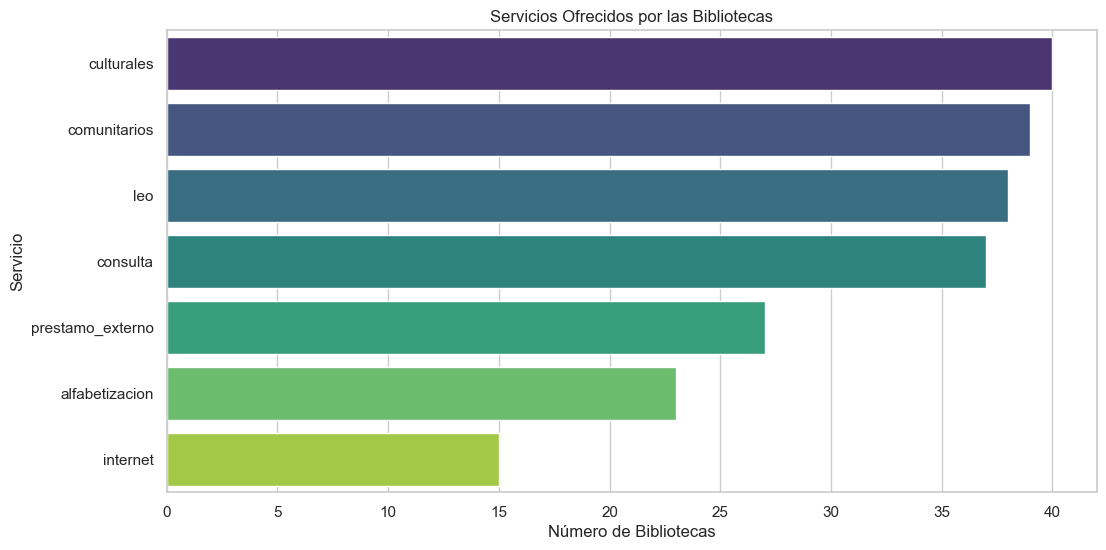

In [12]:
# Gráfico de barras de servicios ofrecidos
plt.figure(figsize=(12, 6))
sns.barplot(data=df_servicios, x='NumeroDeBibliotecas', y='Servicio', palette='viridis')
plt.title('Servicios Ofrecidos por las Bibliotecas')
plt.xlabel('Número de Bibliotecas')
plt.ylabel('Servicio')
plt.show()


# Conclusiones
En este análisis exploratorio, hemos obtenido información valiosa sobre las bibliotecas comunitarias de Bogotá. Podemos destacar:

* La distribución geográfica muestra las localidades con mayor y menor número de bibliotecas.
* La presencia en redes sociales indica las plataformas más utilizadas y oportunidades para fortalecer la comunicación digital.
* Los tipos de colecciones reflejan la diversidad y especialización de las bibliotecas.
* El uso de tecnología y conectividad resalta las bibliotecas con acceso a internet y las que podrían beneficiarse de mejoras tecnológicas.
* Los servicios ofrecidos permiten identificar las necesidades y demandas de las comunidades atendidas.

# Cierre de la Conexión
Finalmente, cerraremos la conexión con la base de datos.

In [13]:
neo4j_repo.close()

2024-11-18 08:42:01,949 - INFO - Neo4jRepository connection closed


# Nota
Este cuaderno está diseñado para ser ejecutado en un entorno donde la base de datos Neo4j está configurada correctamente y los datos mencionados están cargados en el grafo. Asegúrate de actualizar las credenciales de conexión y verificar que las etiquetas y relaciones en las consultas coincidan con tu modelo de datos.